In [7]:
import pickle
from transformers import BertJapaneseTokenizer, BertForMaskedLM
import pandas as pd
import json
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
import seaborn as sns
import collections

In [9]:
with open(".\orignal_data.pkl", "rb") as myprofile:  
    dt = pickle.load(myprofile)
dt.head(2)

,Y,X,L
0,1,当連結会計年度におけるわが国経済は、政府の経済政策や日銀の金融緩和策により、企業業績、雇用・...,154
1,0,当社グループを取り巻く環境は、実質賃金が伸び悩むなか、消費者の皆様の生活防衛意識の高まりや節...,135


<AxesSubplot:xlabel='Y', ylabel='count'>

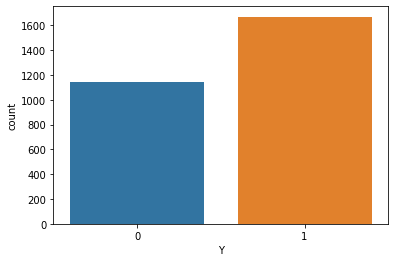

In [10]:
sns.countplot(data = dt,x = "Y")

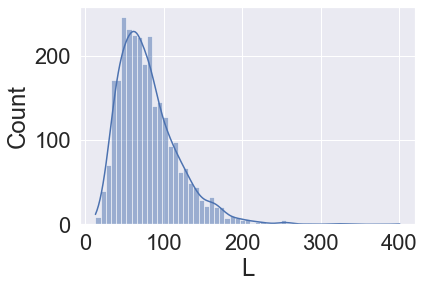

In [11]:
#plt.rcParams['axes.labelsize'] = 10
sns.set(font_scale = 2)
plt.rcParams['text.color'] = 'blue'
#plt.rcParams['font.size'] = 10
sns.histplot(data = dt,x = "L",kde=True)
plt.show()

In [12]:
dt["L"].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

count    2813.00000
mean       80.36829
std        38.97688
min        13.00000
10%        39.00000
20%        48.00000
30%        57.00000
40%        65.00000
50%        73.00000
60%        82.00000
70%        92.00000
80%       107.00000
90%       131.00000
100%      401.00000
max       401.00000
Name: L, dtype: float64

In [13]:
LABEL_VALUES = [0, 1]
label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i

In [14]:
label_map[0]

0

In [15]:
from transformers import DistilBertTokenizer
max_seq_length = 110
train_output_file = "train_data.tfrecord"
test_output_file = "test_data.tfrecord"
tokenizer = DistilBertTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


In [16]:
def create_tf_data_file(dt,output_file):
    tf_record_writer = tf.io.TFRecordWriter(output_file)
    for i in range(dt.shape[0]):
        all_features = collections.OrderedDict()
        text = dt["X"][i]
        encode_plus_tokens = tokenizer.encode_plus(text,padding='max_length',max_length=max_seq_length,truncation=True)
        input_ids = encode_plus_tokens["input_ids"]
        input_mask = encode_plus_tokens["attention_mask"]
        segment_ids = [0] * max_seq_length
        label_id = text = dt["Y"][i]
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())
    tf_record_writer.close()

In [3]:
from sklearn.model_selection import train_test_split

In [22]:
dt_train,dt_test = train_test_split(dt,test_size=0.2,stratify = dt["Y"])
dt_train = dt_train.reset_index()
dt_test = dt_test.reset_index()

In [24]:
create_tf_data_file(dt_train,train_output_file)
create_tf_data_file(dt_test,test_output_file)